In [26]:
# elasticsearch support
from elasticsearch5 import Elasticsearch

# utility includes
import argparse
import json
import math
import pprint
import re
import sys

# visualizations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ES = Elasticsearch()

indexName = 'logstash-test8'


In [ ]:
# Create the index
# print (init_index(indexName))

In [24]:
sessionId = '22c28f175babee3ae68133aad103612b|2019011521'
fields = ["@timestamp", "recordType"]
#fields = None
#pprint.pprint(get_session_events(indexName, sessionId, fields))

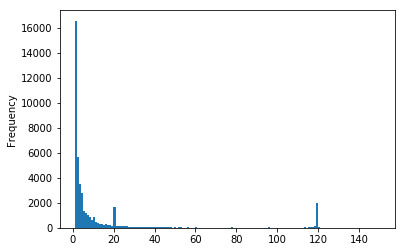

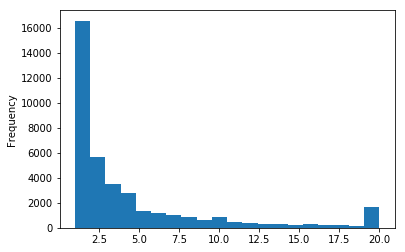

In [31]:
# number of events per session


sessionList = (get_session_ids(indexName))
#pprint.pprint (sessionList)

x = [d['doc_count'] for d in sessionList['aggregations']['unique_sid']['buckets']]
#x = [math.log(d['doc_count']) for d in sessionList['aggregations']['uniqe_sid']['buckets']]

# frequency table of number of events per session
#def print_full(x):
#    pd.set_option('display.max_rows', len(x))
#    print(x)
#    pd.reset_option('display.max_rows')
#print_full(pd.Series(x).value_counts().sort_index())

# histogram of number of events per session (events <= 150)
plt.hist(x, range=[1, 150], bins=150)
plt.ylabel('Frequency')
plt.show()

# histogram of number of events per session (events <= 20)
plt.hist(x, range=[1, 20], bins=20)
plt.ylabel('Frequency')
plt.show()



In [28]:
# fixme: this code should be updated to use the scan helper for performance and to eliminate the arbitrary query size
def get_queries(indexname, fields = None):
    searchbody = {
        "from": 0,
        "size": 10000,
        "_source": [
            "@timestamp",
            "sessionId",
            "queryParts.q"
        ],
        "query": {
            "bool": {
                "must": [
                    {
                        "exists": {
                            "field": "queryParts.q"
                        }
                    }
                ]
            }
        }
    }

    # if querytype is 'end', we want the chronological last event
    # so reverse the sort order to descending over timestamp
    if fields:
        searchbody["_source"] = fields
    
    events = ES.search(index=indexname, body=searchbody)

    return events

queries = get_queries(indexName)
queryList = [q['_source']['queryParts']['q'] for q in queries['hits']['hits']]
queryTerms = []
for q in queryList:
    r = re.search('obsoletedBy:\*\+(.*)\+formatType:', q)
    if r:
        queryTerms.append(r.group(1))
    
queryTerms.sort()
print (len(queryTerms))
pprint.pprint(queryTerms)


3816
[u'" air quality milan"+"air quality"',
 u'" united states geological survey"',
 u'"- Umatilla National Forest"',
 u'"- Umatilla National Forest"+"Umatilla National Forest Southend Barometer "',
 u'"2008 recession"',
 u'"A Study of Researcher Practices and Needs"',
 u'"Actinemys marmorata"',
 u'"Action lake"',
 u'"American beech"',
 u'"American beech"',
 u'"American beech"',
 u'"American beech"',
 u'"American beech"+mast',
 u'"American beech"+mast',
 u'"American beech"+mast+nut',
 u'"Anaxyrus californicus"',
 u'"Anodonta californiensis"',
 u'"Anodonta californiensis"+"Gasterosteus aculeatus"',
 u'"Ant phenology"+"Pacific northwest"',
 u'"Armenian Genocide"+"World War I"',
 u'"Bat "',
 u'"Bat "+Foraging',
 u'"Bonanza Creek"',
 u'"CO2 emissions"',
 u'"CO2 flux"',
 u'"Callosobruchus maculatus"',
 u'"Callosobruchus maculatus"',
 u'"Callosobruchus maculatus"',
 u'"Callosobruchus maculatus"',
 u'"Callosobruchus maculatus"',
 u'"Callosobruchus maculatus"',
 u'"Callosobruchus maculatus"',

 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate data',
 u'climate+climate',
 u'climate+climate',
 u'c

In [29]:
# fixme: this code should be updated to use the scan helper for performance and to eliminate the arbitrary query size
def get_ips(indexname):
    searchbody = {
        "size":"0",
        "aggs" : {
            "unique_ip" : {
                "terms" : { "field" : "geoip.ip", "size" : "10000" }
            }
        }    
    }

    events = ES.search(index=indexname, body=searchbody)

    return events

ipEvents = get_ips(indexName)
ips = [d['key'] for d in ipEvents['aggregations']['unique_ip']['buckets']]
pprint.pprint(ipEvents)

{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
 u'aggregations': {u'unique_ip': {u'buckets': [{u'doc_count': 900769,
                                                u'key': u'64.71.82.7'},
                                               {u'doc_count': 290243,
                                                u'key': u'129.24.63.59'},
                                               {u'doc_count': 282031,
                                                u'key': u'128.227.52.2'},
                                               {u'doc_count': 160140,
                                                u'key': u'128.111.84.26'},
                                               {u'doc_count': 58759,
                                                u'key': u'174.82.138.148'},
                                               {u'doc_count': 56787,
                                                u'key': u'128.111.54.80'},
                                               {u'doc_count':

                                               {u'doc_count': 120,
                                                u'key': u'203.133.170.214'},
                                               {u'doc_count': 119,
                                                u'key': u'73.22.119.253'},
                                               {u'doc_count': 119,
                                                u'key': u'202.113.11.125'},
                                               {u'doc_count': 119,
                                                u'key': u'218.214.188.14'},
                                               {u'doc_count': 118,
                                                u'key': u'216.96.220.152'},
                                               {u'doc_count': 117,
                                                u'key': u'24.16.123.3'},
                                               {u'doc_count': 117,
                                                u'key': u'66.249.69.167'},
   

                                                u'key': u'113.87.41.40'},
                                               {u'doc_count': 35,
                                                u'key': u'128.193.152.96'},
                                               {u'doc_count': 35,
                                                u'key': u'129.234.16.71'},
                                               {u'doc_count': 35,
                                                u'key': u'131.188.6.20'},
                                               {u'doc_count': 35,
                                                u'key': u'147.237.70.107'},
                                               {u'doc_count': 35,
                                                u'key': u'152.115.61.162'},
                                               {u'doc_count': 35,
                                                u'key': u'190.147.107.63'},
                                               {u'doc_count': 35,
           

                                                u'key': u'192.249.3.223'},
                                               {u'doc_count': 20,
                                                u'key': u'193.136.33.145'},
                                               {u'doc_count': 20,
                                                u'key': u'195.161.41.11'},
                                               {u'doc_count': 20,
                                                u'key': u'196.27.0.122'},
                                               {u'doc_count': 20,
                                                u'key': u'197.255.118.134'},
                                               {u'doc_count': 20,
                                                u'key': u'198.7.200.136'},
                                               {u'doc_count': 20,
                                                u'key': u'200.132.38.201'},
                                               {u'doc_count': 20,
          

                                               {u'doc_count': 13,
                                                u'key': u'155.145.195.134'},
                                               {u'doc_count': 13,
                                                u'key': u'156.35.44.153'},
                                               {u'doc_count': 13,
                                                u'key': u'157.55.39.187'},
                                               {u'doc_count': 13,
                                                u'key': u'166.7.29.161'},
                                               {u'doc_count': 13,
                                                u'key': u'168.68.129.127'},
                                               {u'doc_count': 13,
                                                u'key': u'169.226.41.8'},
                                               {u'doc_count': 13,
                                                u'key': u'169.231.82.165'},
           

                                               {u'doc_count': 9,
                                                u'key': u'107.77.200.218'},
                                               {u'doc_count': 9,
                                                u'key': u'108.48.231.81'},
                                               {u'doc_count': 9,
                                                u'key': u'108.53.32.152'},
                                               {u'doc_count': 9,
                                                u'key': u'109.252.55.166'},
                                               {u'doc_count': 9,
                                                u'key': u'113.200.245.42'},
                                               {u'doc_count': 9,
                                                u'key': u'117.136.8.233'},
                                               {u'doc_count': 9,
                                                u'key': u'118.185.236.102'},
               

                                                u'key': u'129.89.232.56'},
                                               {u'doc_count': 7,
                                                u'key': u'129.89.239.172'},
                                               {u'doc_count': 7,
                                                u'key': u'129.114.110.152'},
                                               {u'doc_count': 7,
                                                u'key': u'129.170.194.183'},
                                               {u'doc_count': 7,
                                                u'key': u'129.234.104.101'},
                                               {u'doc_count': 7,
                                                u'key': u'129.236.6.17'},
                                               {u'doc_count': 7,
                                                u'key': u'130.60.20.206'},
                                               {u'doc_count': 7,
              

                                               {u'doc_count': 6,
                                                u'key': u'184.185.222.16'},
                                               {u'doc_count': 6,
                                                u'key': u'187.26.69.64'},
                                               {u'doc_count': 6,
                                                u'key': u'188.219.224.18'},
                                               {u'doc_count': 6,
                                                u'key': u'188.243.58.176'},
                                               {u'doc_count': 6,
                                                u'key': u'190.116.102.68'},
                                               {u'doc_count': 6,
                                                u'key': u'190.235.179.1'},
                                               {u'doc_count': 6,
                                                u'key': u'191.189.14.199'},
                

                                               {u'doc_count': 4,
                                                u'key': u'40.77.189.157'},
                                               {u'doc_count': 4,
                                                u'key': u'40.107.235.18'},
                                               {u'doc_count': 4,
                                                u'key': u'40.107.235.23'},
                                               {u'doc_count': 4,
                                                u'key': u'40.107.235.41'},
                                               {u'doc_count': 4,
                                                u'key': u'40.107.235.52'},
                                               {u'doc_count': 4,
                                                u'key': u'40.107.235.75'},
                                               {u'doc_count': 4,
                                                u'key': u'40.107.235.82'},
                    

                                               {u'doc_count': 4,
                                                u'key': u'180.76.15.28'},
                                               {u'doc_count': 4,
                                                u'key': u'180.76.15.141'},
                                               {u'doc_count': 4,
                                                u'key': u'180.76.15.142'},
                                               {u'doc_count': 4,
                                                u'key': u'180.76.15.150'},
                                               {u'doc_count': 4,
                                                u'key': u'180.76.15.163'},
                                               {u'doc_count': 4,
                                                u'key': u'183.160.239.37'},
                                               {u'doc_count': 4,
                                                u'key': u'184.166.40.56'},
                    

                                                u'key': u'77.49.8.52'},
                                               {u'doc_count': 3,
                                                u'key': u'77.111.244.10'},
                                               {u'doc_count': 3,
                                                u'key': u'77.111.247.185'},
                                               {u'doc_count': 3,
                                                u'key': u'77.136.200.122'},
                                               {u'doc_count': 3,
                                                u'key': u'77.162.248.84'},
                                               {u'doc_count': 3,
                                                u'key': u'77.234.44.142'},
                                               {u'doc_count': 3,
                                                u'key': u'77.247.181.163'},
                                               {u'doc_count': 3,
                    

                                               {u'doc_count': 3,
                                                u'key': u'190.136.61.123'},
                                               {u'doc_count': 3,
                                                u'key': u'190.236.12.134'},
                                               {u'doc_count': 3,
                                                u'key': u'190.239.111.51'},
                                               {u'doc_count': 3,
                                                u'key': u'190.248.80.51'},
                                               {u'doc_count': 3,
                                                u'key': u'191.176.30.159'},
                                               {u'doc_count': 3,
                                                u'key': u'191.189.8.217'},
                                               {u'doc_count': 3,
                                                u'key': u'191.189.18.203'},
               

                                                u'key': u'66.153.250.199'},
                                               {u'doc_count': 2,
                                                u'key': u'66.183.231.140'},
                                               {u'doc_count': 2,
                                                u'key': u'66.194.72.22'},
                                               {u'doc_count': 2,
                                                u'key': u'66.208.36.226'},
                                               {u'doc_count': 2,
                                                u'key': u'66.212.200.9'},
                                               {u'doc_count': 2,
                                                u'key': u'66.215.51.199'},
                                               {u'doc_count': 2,
                                                u'key': u'66.220.149.27'},
                                               {u'doc_count': 2,
                    

                                                u'key': u'134.82.176.67'},
                                               {u'doc_count': 2,
                                                u'key': u'134.87.133.5'},
                                               {u'doc_count': 2,
                                                u'key': u'134.117.247.192'},
                                               {u'doc_count': 2,
                                                u'key': u'134.139.30.45'},
                                               {u'doc_count': 2,
                                                u'key': u'134.139.33.12'},
                                               {u'doc_count': 2,
                                                u'key': u'134.161.28.128'},
                                               {u'doc_count': 2,
                                                u'key': u'134.161.235.196'},
                                               {u'doc_count': 2,
                

                                                u'key': u'217.115.34.254'},
                                               {u'doc_count': 2,
                                                u'key': u'217.138.49.66'},
                                               {u'doc_count': 2,
                                                u'key': u'217.149.174.188'},
                                               {u'doc_count': 2,
                                                u'key': u'217.165.22.20'},
                                               {u'doc_count': 2,
                                                u'key': u'217.244.226.196'},
                                               {u'doc_count': 2,
                                                u'key': u'218.103.130.137'},
                                               {u'doc_count': 2,
                                                u'key': u'219.142.99.26'},
                                               {u'doc_count': 2,
             

                                               {u'doc_count': 1,
                                                u'key': u'66.102.6.111'},
                                               {u'doc_count': 1,
                                                u'key': u'66.102.6.113'},
                                               {u'doc_count': 1,
                                                u'key': u'66.102.6.117'},
                                               {u'doc_count': 1,
                                                u'key': u'66.102.6.209'},
                                               {u'doc_count': 1,
                                                u'key': u'66.102.8.7'},
                                               {u'doc_count': 1,
                                                u'key': u'66.102.8.169'},
                                               {u'doc_count': 1,
                                                u'key': u'66.102.8.171'},
                             

                                                u'key': u'124.17.34.70'},
                                               {u'doc_count': 1,
                                                u'key': u'124.170.151.113'},
                                               {u'doc_count': 1,
                                                u'key': u'125.202.254.136'},
                                               {u'doc_count': 1,
                                                u'key': u'125.209.235.167'},
                                               {u'doc_count': 1,
                                                u'key': u'125.209.235.169'},
                                               {u'doc_count': 1,
                                                u'key': u'125.209.235.174'},
                                               {u'doc_count': 1,
                                                u'key': u'125.209.235.179'},
                                               {u'doc_count': 1,
         

                                               {u'doc_count': 1,
                                                u'key': u'186.6.70.185'},
                                               {u'doc_count': 1,
                                                u'key': u'186.151.60.207'},
                                               {u'doc_count': 1,
                                                u'key': u'187.6.15.129'},
                                               {u'doc_count': 1,
                                                u'key': u'187.147.194.31'},
                                               {u'doc_count': 1,
                                                u'key': u'187.189.103.103'},
                                               {u'doc_count': 1,
                                                u'key': u'187.192.137.157'},
                                               {u'doc_count': 1,
                                                u'key': u'187.210.230.48'},
               

In [20]:
# fixme: this code should be updated to use the scan helper for performance and to eliminate the arbitrary query size
def get_session_ids(indexname):
    searchbody = {
        "size":"0",
        "aggs" : {
            "unique_sid" : {
                "terms" : { "field" : "sessionId", "size" : "60000" }
            }
        }    
    }

    events = ES.search(index=indexname, body=searchbody)

    return events


In [9]:
def get_session_events(indexname, sessionid, fields = None):
    searchbody = {
        "from": 0,
        "size": 100,
        "_source": [
            "@timestamp",
            "sessionId",
            "xgeoip",
            "recordType",
            "status",
            "request",
            "formatType",
            "formatId"
        ],
        "query": {
            "bool": {
                "must": [
                    {
                        "exists": {
                            "field": "sessionId"
                        }
                    },
                    {
                        "match_phrase": {
                            "sessionId": {
                                "query": "22c28f175babee3ae68133aad103612b|2019011521"
                            }
                        }
                    },
                ]
            }
        },
        "sort": [ 
            {
                "@timestamp": {
                    "order": "asc",
                    "unmapped_type": "date"
                }
            }
        ]
    }

    # if a fields collection exists, overwrite the default fields encoded in the query
    if fields:
        searchbody["_source"] = fields
    
    events = ES.search(index=indexname, body=searchbody)

    return events

In [23]:
def init_index(indexname):
    # Create an index including specific attributes
    # in order to assign their data types
    indexconfig = {
        "mappings": {
            "doc" : {
                "properties": {
                    "sessionId": {"type": "keyword"},
                    "recordType": {"type": "keyword"},
                    "userAgent": {"type": "keyword"},
                    "pid": {"type": "keyword"},
                    "nodeId": {"type": "keyword"}
                }
            }
        }
    }

    try:
        ES.indices.create(indexname, indexconfig)
    except Exception as e:
        print e
        return 1
    return 0

